**참고문헌: 핸즈온 머신러닝(2판), 올레리앙 제롱 지음, 박해선 옮김, 11장 – 심층 신경망 훈련하기**

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지와 텐서플로 버전이 2.0 이상인지 확인합니다.

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 그레이디언트 소실과 폭주 문제

역전파 알고리즘은 출력층에서 입력층으로 오차 그레이디언트를 전파하면서 진행됩니다. 알고리즘이 신경망의 모든 파라미터에 대한 오차 함수의 그레이디언트를 계산하면 경사 하강법 단계에서 이 그레이디언트를 사용하여 각 파라미터를 수정합니다.

그런데 알고리즘 하위층으로 진행될수도록 그레이디언트가 점점 작아지는 경우가 많습니다. 경사 하강법이 하위층의 연결 가중치를 변경되지 않은 채로 둔다면 안타깝게도 훈련이 좋은 솔류션으로 수렴되지 않을 것입니다. 이 문제를 그레이디언트 소실(vanishing gradient)라고 합니다. 어떤 경우엔 반대 현상이 일어날수 있습니다. 그레이디언트가 점점 커져서 여러 층이 비정상적으로 큰 가중치로 갱신되면 알고리즘은 발산(diverse)합니다. 이 문제를 그레이디언트 폭주(exploding gradient)라고 하며, 순환 신경망에서 주로 나타압니다.

이런 좋지 않은 학습 패턴이 꽤 오랫동안 경험적으로 촨측되었습니다. 2000년 초까지 심층 신경망이 거의 방치되었던 이유 중 하나입니다.  심층 신경망을 훈련할 때 그레이디언트를 불안정하게 만드는 원인이 무엇인지 명확하지 않았습니다. 심층 신경망을 훈련할 때 그레이디언트를 불안정하게 만드는 원이이 무엇인지 명확하지 않았습니다. 2010년 세이비어 클로럿(Xavier Glorot)과 요슈아 벤지오(Yoshua Bengio)가 발표한 논문(http://proceedings.mlr.press/v9/glorot10a) 덕분에 이에 대한 이해가 많이 진전 되었습니다. 저자들은 의심되는 원인을 몇 가지 발견했는데, 그중에는 많이 사용되는 로지스틱 시크모이드 활성화 함수와 그 당시 가장 인기 있던 가중치 초기화 방법(즉, 평균이 0이고 표준편차 1인 정규분포)의 조합이었습니다. 이 ㅅ활성화 함수와 초기화 방식을 사용했을 때 각 층에서 출력의 분삭이 입력의 분산보다 더 크다는 것을 밝혔습니다. 신경망의 위쪽으로 갈수록 층을 지날 때마다 분산이 계속 커져 가장 높은 층에서는 활성화 함수가 0 이나 1로 수렴합니다. 이는 로지스틱 함수의 평균이 0이 아니고 0.5라는 사실 때문에 더 나빠집니다. 

로지스틱 활성화 함수를 보면 입력 커지면 0이나 1로 수렴해서 기울기가 0에 매우 가까워지는 것을 알 수 있습니다. 그래서 역전파가 될 때 사실상 신경망으로 전파할 그레이디언트가 거의 없고 조금 있는 그레이디언트는 최상위층에서부터 역전파가 진행되면서 점차 약해져서 실제로 아래쪽 층에 아무것도 도달하지 않게 됩니다.


In [ ]:
def logit(z):
    return 1 / (1 + np.exp(-z))

그림 저장: sigmoid_saturation_plot


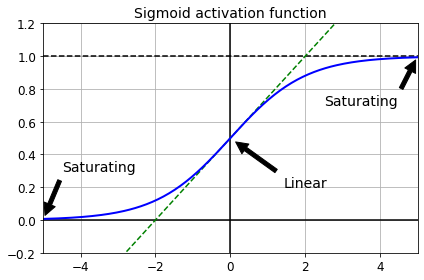

In [ ]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier 초기화 (2010년)와 He 초기화(2015년)

글로럿과 벤지오는 논문에서 불안정한 그레이디언트 문제를 크게 완화하는 방법을 제안합니다. 예측을 할 때는 정방향으로, 그레이디언트를 역전파할 때는 역방향으로 양방향 신호가 적절하게 흘러야합니다. 신호가 죽거나 폴주 또는 소멸하지 않아야합니다. 저자들은 적절한 신호가 흐르기 위해서는 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다고 주장합니다. 

그리고 역방향에서 층을 통과하기 전과 후의 그레이디언트 분산이 동일해야 합니다 (). 사실 층의 입력과 출력 연결 개수(이 개수를 층의 팬-인(fan-in)과 팬-아웃(fan-out)이라고 부릅니다)가 같지 않다면 이 두가지를 보장할 수 없습니다. 하지만 글로럿과 벤지오는 실전에서 매우 잘 작동한다고 입증된 대안을 제안하였습니다. 각 층의 연결 가중치를**[식11-1]**에 기술한 방식대로 무작위로 초기화하는 것입니다. 


**Equation 11-1: Xavier initialization (when using the logistic activation function)**

$
\begin{split}
& \text{Normal distribution with mean 0 and standard deviation }
\sigma = \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}}\\
& \text{Or a uniform distribution between -r and +r, with }
r = \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}}
\end{split}
$

In [ ]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

**Equation 11-1: He initialization**

$
\begin{split}
& \text{Normal distribution with mean 0 and standard deviation }
\sigma = \sqrt{\dfrac{2}{n_\text{inputs} }}\\
& \text{Or a uniform distribution between -r and +r, with }
r = \sqrt{\dfrac{6}{n_\text{inputs}}}
\end{split}
$

케라스는 기본적으로 균등분포의 글로럿 초기화를 사용합니다. 다음과 같이 층을 만들 때  kernel_initializer="he_uniform"이나 kernel_initializer="he_normal"로 바꾸어 He 초기화를 사용할 수 있습니다.

In [ ]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

fan_in 대신 fan_avg 기반의 균등분포 He 초기화를 사용하고 싶다면 다음과 같이 Variance Scaling을 사용할 수 있습니다. 

In [ ]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

* VarianceScaling 클래스의 매개 변수 기본값은 scale=1.0, mode ='fan_in',  distribution='truncated_normal'입니다. 절단 정규분포(distribution='truncated_normal')경우에는 분포 = 1.3 x scale/mode로 계싼됩니다. 정규 분포 (distribution='untruncated_normal')일 경우에는 분포 = scale/mode)로 계산됩니다. 케라스 층의 kernel_initializer 매개 변수의 기본값은 'glorot_uniform"으로 VarianceScaling(scale=1.0, mode ='fan_avg',  distribution='uniform')을 사용합니다. 'he_normal' 경우  VarianceScaling(scale=2.0, mode ='fan_in',  distribution='truncated_normal')을 사용합니다. 'lecun_normal'일 경우 VarianceScaling 클래스의 기본값을 사용합니다.

**Table 11-1: Initialization parameters for each type of activation function**

* Logistic uniform: $ r = \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $
* Logistic normal: $ \sigma = \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $
* Hyperbolic tangent uniform: $ r = 4 \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $
* Hyperbolic tangent normal: $ \sigma = 4 \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $
* ReLU (and its variants) uniform: $ r = \sqrt{2} \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $
* ReLU (and its variants) normal: $ \sigma = \sqrt{2} \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $


# [예제] Initialization 초기화 
출처: https://junstar92.tistory.com/101 

초기화하는 방법에 따라서, Gradient Descent의 수렴 속도를 증가시킬 수 있고 training error를 더 낮게 학습할 수 있습니다.

실습에서는 numpy를 사용해서 1) 0으로 초기화, 2) random 초기화(np.random.randn), 3) he 초기화를 사용했습니다.
 
우선 테스트하기 전 필요한 함수들과 data를 읽어오겠습니다.





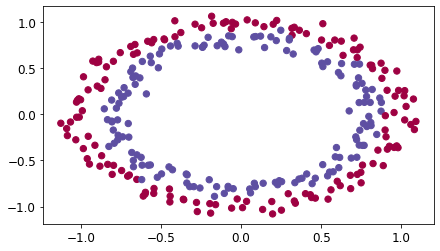

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
%matplotlib inline

plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    return train_X, train_Y, test_X, test_Y


# load image dataset: blue/red dots in circles
train_X, train_Y, test_X, test_Y = load_dataset()

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()

그리고 매번 동일한 랜덤값을 얻기 위한 global seed 설정과 operation seed로 사용할 값을 지정합니다.


In [ ]:
def set_global_seed():
    tf.random.set_seed(2)
SEED = 1


##  1. Neural Network Model 구현


테스트에 사용할 NN은 3개의 layer를 가진 NN입니다.  input -> 1st layer(10 units, relu) -> 2nd layer(5 units, relu) -> output layer(sigmoid) -> output 로 이루어져있습니다.

In [ ]:
layers_dims = [train_X.shape[1], 10, 5, 1]
 
def Model(layers_dims, learning_rate=0.01, initialization='random'):
    set_global_seed()
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(layers_dims[0],)))
    
    if initialization=='zeros':
        initializer=init_zeros
    elif initialization=='random':
        initializer=init_random
    elif initialization=='he':
        initializer=init_he
        
    n_layer = len(layers_dims)
    for i in range(1, n_layer):
        if i != n_layer-1:
            model.add(tf.keras.layers.Dense(
                layers_dims[i], activation='relu', kernel_initializer=initializer
            ))
        else:
            model.add(tf.keras.layers.Dense(
                layers_dims[i], activation='sigmoid', kernel_initializer=initializer
            ))
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    # print('파라미터: ', model.get_weights()[0])
    
    return model


각각의 초기화는 init_zero, init_random, init_he를 통해서 정해지고, 자세한 확인은 초기화 class를 만들고나서 해보도록 하겠습니다. bias_initializer는 설정하지 않으면 자동으로 0으로 초기화되므로 따로 설정하지 않았습니다.

그리고 모델을 생성할 때마다 동일하게 초기화하기 위해서 global seed를 모델을 생성하기 전에 지정해주도록 했습니다.

## 2. Initialization Class 구현


initializer는 tf.keras.initializers.Initializer를 상속하는 class를 생성해서 model의 layer를 추가할때, kernel_initializer의 인자로 사용할 것입니다


***Zero initialization***
zero 초기화 class구현은 간단합니다. __init__을 따로 정의할 필요는 없고, 해당 class를 사용할 때, __call__을 통해서 파라미터를 반환하게 되는데, 단순 0으로 초기화할 것이므로 tf.zeros를 통해서 0으로 초기화된 Tensor를 반환하면 됩니다. 직접 구현하지 않고, tf.keras.initializers.Zeros()를 사용해도 됩니다 !

In [ ]:
class init_zeros(tf.keras.initializers.Initializer):
    def __call__(self, shape, dtype=None):
        return tf.zeros(shape, dtype=dtype, name=None)

***random initialization***

실습에서 random 초기화에 np.random.randn을 사용했습니다. 이 함수는 평균이 0, 분산이 1인 가우시안 정규분포로 이 값들 중에서 임의로 초기화를 하게 됩니다. 테스트를 정확하게 하기 위해서 tf.random.normal에 seed를 설정해주었습니다. 그리고 초기화한 파라미터에 10을 곱해주었습니다.


In [ ]:
class init_random(tf.keras.initializers.Initializer):
    def __init__(self, mean=0, stddev=1):
        self.mean = mean
        self.stddev = stddev
    
    def __call__(self, shape, dtype=None):
        return tf.random.normal(
            shape, mean=self.mean, stddev=self.stddev, seed=SEED, dtype=dtype)*10

***he initialization***



In [ ]:
class init_he(tf.keras.initializers.Initializer):
    def __init__(self, mean=0, stddev=1):
        self.mean = mean
        self.stddev = stddev
    
    def __call__(self, shape, dtype=None):
        return tf.random.normal(
            shape, mean=self.mean, stddev=self.stddev, seed=SEED, dtype=dtype)*np.sqrt(2/shape[0])


이렇게 3개의 초기화 class를 만들어주었습니다. 각각의 모델을 생성하게 되면, 다음과 같이 초기화된 것을 확인할 수 있습니다. 

In [ ]:
Model(layers_dims, initialization='zeros')
Model(layers_dims, initialization='random')
Model(layers_dims, initialization='he')

이제부턴 print는 주석처리하고 진행하도록 합니다 !

## 3. 학습

***zero initialization의 경우***

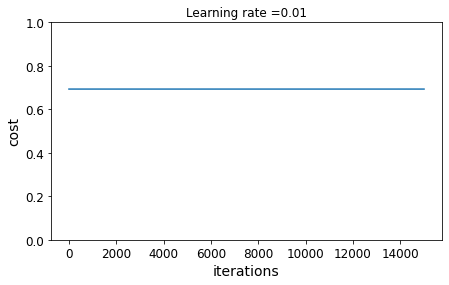

After training, Cost: 0.6931883692741394 - Accuracy: 0.5


In [ ]:
zero_init_model=Model(layers_dims, initialization='zeros')
hist_zero = zero_init_model.fit(train_X, train_Y, epochs=15000, verbose=0)
 
# plot the cost
plt.plot(np.squeeze(hist_zero.history['loss']))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.01))
plt.ylim([0, 1])
plt.show()
 
print(f"After training, Cost: {hist_zero.history['loss'][-1]} - Accuracy: {hist_zero.history['accuracy'][-1]}")

딥러닝에서 0으로 초기화하는 경우 네트워크는 break symmetry에 실패하기 때문에, 각 layer들의 unit이 모두 같은 값으로 학습이 되어서 모든 layer가 unit이 1개인 것처럼 동작하게 됩니다.

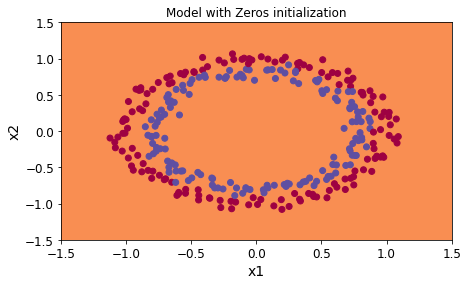

In [ ]:
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: zero_init_model.predict(x) > 0.5, train_X, train_Y)

***random initialization***


random 초기화로 수행하면 어떻게 되는지 살펴보겠습니다.

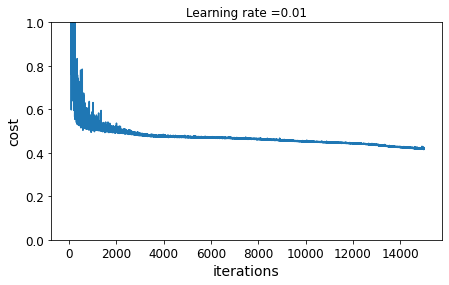

After training, Cost: 0.4185068905353546 - Accuracy: 0.7633333206176758
4/4 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5000


[0.6931503415107727, 0.5]

In [ ]:
random_init_model = Model(layers_dims, initialization='random')
random_model_hist = random_init_model.fit(train_X, train_Y, epochs=15000, verbose=0)
 
# plot the cost
plt.plot(np.squeeze(random_model_hist.history['loss']))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.01))
plt.ylim([0, 1])
plt.show()
 
print(f"After training, Cost: {random_model_hist.history['loss'][-1]} - Accuracy: {random_model_hist.history['accuracy'][-1]}")
zero_init_model.evaluate(test_X, test_Y)

이전보다는 꽤 괜찮은 결과를 얻었습니다. 

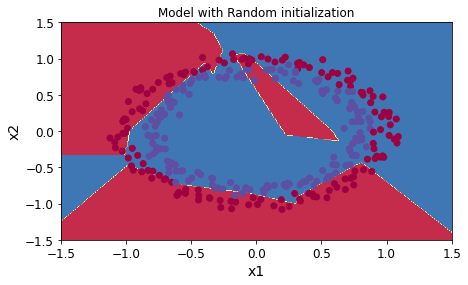

In [ ]:
plt.title("Model with Random initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: random_init_model.predict(x) > 0.5, train_X, train_Y)

***He initialization***

마지막으로 he initialization을 사용해서 학습해보도록 하겠습니다.


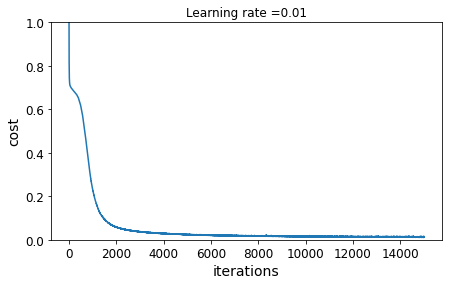

After training, Cost: 0.01141868345439434 - Accuracy: 0.996666669845581
4/4 [==============================] - 0s 4ms/step - loss: 0.2134 - accuracy: 0.9400


[0.21344056725502014, 0.9399999976158142]

In [ ]:
he_init_model = Model(layers_dims, initialization='he')
hist_he = he_init_model.fit(train_X, train_Y, epochs=15000, verbose=0)
 
# plot the cost
plt.plot(np.squeeze(hist_he.history['loss']))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.01))
plt.ylim([0, 1])
plt.show()
 
print(f"After training, Cost: {hist_he.history['loss'][-1]} - Accuracy: {hist_he.history['accuracy'][-1]}")
he_init_model.evaluate(test_X, test_Y)

99%의 training 정확도와 94%의 test 정확도를 얻었습니다. 이전과 비교하면 확실히 좋은 결과를 얻게 되었습니다. 아래 decision boundary를 확인해도 꽤 정확한 것을 볼 수 있습니다.

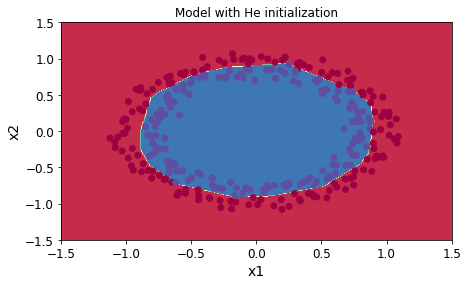

In [ ]:
plt.title("Model with He initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: he_init_model.predict(x) > 0.5, train_X, train_Y)

확실히 초기화를 어떻게 하느냐에 따라서 학습에 많은 영향을 미치는 것으로 확인이 됩니다.

keras에서는 초기화 방법을 설정하지 않으면 기본적으로 tf.kears.initializiers.GlorotNormal이 적용되는데, 이것은 Xavier normal initilizer를 의미합니다.

## 수렴하지 않는 활성화 함수

글로럿과 벤지오의 2010년 논문에서 얻은 통찰 중 하나는 활성화 함수를 잘못 선택하면 자칫그레이디언트의 소실이나 폭주로 이어질 수 있다는 것입니다. 그전에는 대부분 생물학적 뉴런의 방식과 비슷한 시그모이드 활성화 함수가 최선의 선택일 것이라고 생각했습니다. 하지만 다른 활성화 함수가 심층 신경망에서 훨씬 더 잘 작동한다는 사실이 밝혀졌습니다. 특히 ReLU함수는 특정 양숫값에 수렴하지 않는다는 큰 장점이 있습니다. 

안타깝게도 ReLU 함수는 완벽하지 않습니다., 죽은 ReLU로 알려진 문제가 있습니다.  즉 가중치 합이 음수이면 ReLU함수의 그레이디언트가 0이 되므로 경사 하강법이 더는 작동하지 않습니다.

이 무제를 해결하기 위해 LeakyReLU 같은 ReLU 함수의 변종을 사용합니다.

### LeakyReLU (Bing Xu et al., 2015)

$
\operatorname{LeakyReLU}_\alpha(z) = max(\alpha x,x)
$

In [ ]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

그림 저장: leaky_relu_plot


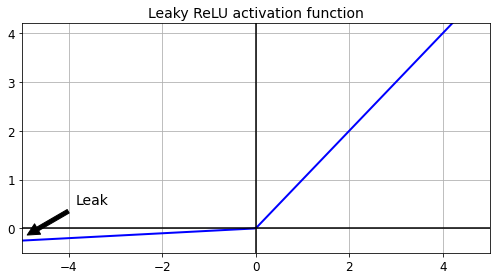

In [ ]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [ ]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [ ]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

LeakyReLU를 사용해 패션 MNIST에서 신경망을 훈련해 보죠:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8202
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5338 - accuracy: 0.8225 - val_loss: 0.5157 - val_accuracy:

LeakyReLU 말고도 PReLU (parametric leaky ReLU)도 사용 할 수 있습니다.

### PReLU (Bing Xu et al., 2015)


$
\operatorname{PReLU}_\alpha(z) =
\begin{cases}
\alpha(z) & \text{if } z < 0\\ z & if z \ge 0
\end{cases}
$

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7632
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6966 - accuracy: 0.7693 - val_loss: 0.6565 - val_accuracy: 0.7880
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6003 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8180
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5618 - accuracy: 0.8134 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5390 - accuracy: 0.8205 - val_loss: 0.5196 - val_accuracy:

### ELU (Djork-Arne Clevert et al., 2016)


$
\operatorname{ELU}_\alpha(z) =
\begin{cases}
\alpha(\exp(z) - 1) & \text{if } z < 0\\
z & if z \ge 0
\end{cases}
$

In [ ]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

그림 저장: elu_plot


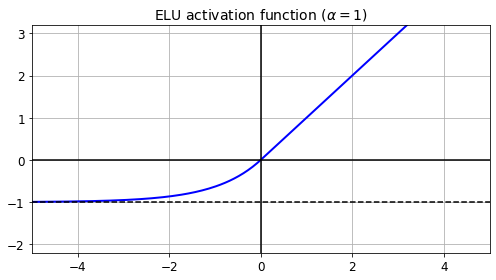

In [ ]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

텐서플로에서 쉽게 ELU를 적용할 수 있습니다. 층을 만들 때 활성화 함수로 지정하면 됩니다:

In [ ]:
keras.layers.Dense(10, activation="elu")

### SELU (Gunter Klambauer et al., 2017)

$
\operatorname{SELU}_{\alpha,\lambda}(z) = \lambda
\begin{cases}
\alpha(\exp(z) - 1) & \text{if } z < 0\\
z & if z \ge 0
\end{cases}
$

Günter Klambauer, Thomas Unterthiner, Andreas Mayr는 2017년 한 [훌륭한 논문](https://arxiv.org/pdf/1706.02515.pdf)에서 SELU 활성화 함수를 소개했습니다. 훈련하는 동안 완전 연결 층만 쌓아서 신경망을 만들고 SELU 활성화 함수와 LeCun 초기화를 사용한다면 자기 정규화됩니다. 각 층의 출력이 평균과
표준편차를 보존하는 경향이 있습니다. 이는 그레이디언트 소실과 폭주 문제를 막아줍니다. 그 결과로 SELU 활성화 함수는 이런 종류의 네트워크(특히 아주 깊은 네트워크)에서 다른 활성화 함수보다 뛰어난 성능을 종종 냅니다. 따라서 꼭 시도해 봐야 합니다. 하지만 SELU 활성화 함수의 자기 정규화 특징은 쉽게 깨집니다. ℓ<sub>1</sub>나 ℓ<sub>2</sub> 정규화, 드롭아웃, 맥스 노름, 스킵 연결이나 시퀀셜하지 않은 다른 토폴로지를 사용할 수 없습니다(즉 순환 신경망은 자기 정규화되지 않습니다). 하지만 실전에서 시퀀셜 CNN과 잘 동작합니다. 자기 정규화가 깨지면 SELU가 다른 활성화 함수보다 더 나은 성능을 내지 않을 것입니다.

In [ ]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [ ]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

그림 저장: selu_plot


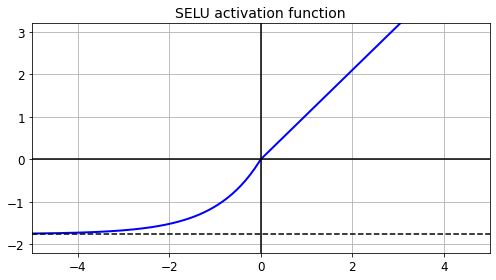

In [ ]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

기본적으로 SELU 하이퍼파라미터(`scale`과 `alpha`)는 각 뉴런의 평균 출력이 0에 가깝고 표준 편차는 1에 가깝도록 조정됩니다(입력은 평균이 0이고 표준 편차 1로 표준화되었다고 가정합니다). 이 활성화 함수를 사용하면 1,000개의 층이 있는 심층 신경망도 모든 층에 걸쳐 거의 평균이 0이고 표준 편차를 1로 유지합니다. 이를 통해 그레이디언트 폭주와 소실 문제를 피할 수 있습니다:

In [ ]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


쉽게 SELU를 사용할 수 있습니다:

In [ ]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

100개의 은닉층과 SELU 활성화 함수를 사용한 패션 MNIST를 위한 신경망을 만들어 보죠:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

이제 훈련해 보죠. 입력을 평균 0과 표준 편차 1로 바꾸어야 한다는 것을 잊지 마세요:

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 39s 20ms/step - loss: 1.0909 - accuracy: 0.5887 - val_loss: 0.8581 - val_accuracy: 0.6928
Epoch 2/5
1719/1719 [==============================] - 34s 20ms/step - loss: 0.7349 - accuracy: 0.7327 - val_loss: 0.6277 - val_accuracy: 0.7676
Epoch 3/5
1719/1719 [==============================] - 37s 22ms/step - loss: 0.7406 - accuracy: 0.7261 - val_loss: 0.7095 - val_accuracy: 0.7268
Epoch 4/5
1719/1719 [==============================] - 34s 20ms/step - loss: 0.6736 - accuracy: 0.7534 - val_loss: 0.6066 - val_accuracy: 0.7864
Epoch 5/5
1719/1719 [==============================] - 34s 20ms/step - loss: 0.6338 - accuracy: 0.7650 - val_loss: 0.5682 - val_accuracy: 0.7870


대신 ReLU 활성화 함수를 사용하면 어떤 일이 일어나는지 확인해 보죠:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 38s 20ms/step - loss: 1.9234 - accuracy: 0.2386 - val_loss: 1.6214 - val_accuracy: 0.2986
Epoch 2/5
1719/1719 [==============================] - 34s 20ms/step - loss: 1.1655 - accuracy: 0.5068 - val_loss: 0.9771 - val_accuracy: 0.5684
Epoch 3/5
1719/1719 [==============================] - 34s 20ms/step - loss: 0.9411 - accuracy: 0.6145 - val_loss: 1.0792 - val_accuracy: 0.5612
Epoch 4/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.8507 - accuracy: 0.6608 - val_loss: 0.7339 - val_accuracy: 0.6998
Epoch 5/5
1719/1719 [==============================] - 34s 20ms/step - loss: 0.7169 - accuracy: 0.7121 - val_loss: 0.6812 - val_accuracy: 0.7330


좋지 않군요. 그레이디언트 폭주나 소실 문제가 발생한 것입니다.

### Tip

심층 신경망의 은닉층에는 어떤 활성화 함수를 써야 할까요? 사람마다 다르겠지만 일반적으로 SELU > ELU > LeakyReLU(그리고 변종들) > ReLU > tanh > 로지스틱 순입니다. 네트워크가 자기 정규화되지 못하는 구조라면 ELU가 SELU보다 성능이 더 나을 수 있습니다 (SELU가 z= 0에서 연속적이지 않기 때문에). 실행 속도가 중요하다면 LeakyReLU를 선택할 수 있습니다. 하이퍼파라미터를 더 추가하고 싶지 않다면 케라스에 사용하는 기본값을 사용합니다. 시간과 컴퓨팅 파워가 충분하다면 교차 검증을 사용해 여러 활성화 함수를 평가해볼 수 있습니다. 특히 신경망이 과대적합되었다면 PReLU를 포함시키면 좋습니다. ReLU가 지금까지 가장 널리 사용되는 활성화 함수이므로 많은 라이브러리와 하드웨어 가속기들은 ReLU에 특화되어 최적화되어있습니다. 따라서 속도가 중요하다면 ReLU가 가장 좋은 선택입니다. 